# Growth Mechanism with Details

In [18]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import colors

sys.path.append('../../src')
from m3_learning.nn.random import random_seed
from m3_learning.viz.style import set_style
from m3_learning.viz.printing import printer
from m3_learning.viz.layout import imagemap, layout_fig, labelfigs
from m3_learning.RHEED.Dataset import RHEED_parameter_dataset, RHEED_spot_Dataset
from m3_learning.RHEED.Viz import Viz
from m3_learning.RHEED.Analysis import detect_peaks, analyze_curves, process_rheed_data 
from m3_learning.RHEED.Packed_functions import decay_curve_examples
from m3_learning.RHEED.Analysis_umich import fit_curves, analyze_rheed_data, analyze_txt_rheed

plot_size = (6, 2)
color_blue = (44/255,123/255,182/255)
color_gray = (128/255, 128/255, 128/255, 0.5)
seq_colors = ['#00429d','#2e59a8','#4771b2','#5d8abd','#73a2c6','#8abccf','#a5d5d8','#c5eddf','#ffffe0']
bgc1, bgc2 = (*colors.hex2color(seq_colors[0]), 0.3), (*colors.hex2color(seq_colors[5]), 0.3)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Visualize the spots from collected data

In [21]:
spot_ds_path = 'F:/UMich/J14_set1_08242023.h5'
D1_spot = RHEED_spot_Dataset(path, sample_name='J14_300C')
D1_spot.data_info

Growth: temp250
Growth: temp300
Growth: temp350


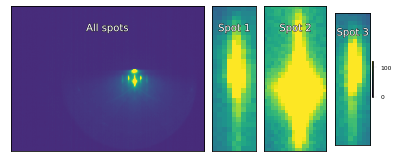

In [10]:
img_all = D1_spot.growth_dataset(growth='temp300', index=0)
img_spot1 = D1_para.growth_dataset(growth='temp300', metric='raw_image', spot='spot_1', index=100)
img_spot2 = D1_para.growth_dataset(growth='temp300', metric='raw_image', spot='spot_2', index=100)
img_spot3 = D1_para.growth_dataset(growth='temp300', metric='raw_image', spot='spot_3', index=100)

imgs = [img_all, img_spot1, img_spot2, img_spot3]
width_ratios = [img.shape[1]/img.shape[0] for img in imgs]
titles = ['All spots', 'Spot 1', 'Spot 2', 'Spot 3']
fig = plt.figure(figsize=(6.5, 3))
gs = gridspec.GridSpec(nrows=1, ncols=4, width_ratios=width_ratios, wspace=0.1)
axes = [fig.add_subplot(gs[i]) for i in range(4)]
for i, ax in enumerate(axes):
    if i == 3:
        imagemap(ax, imgs[i], colorbars=True, clim=(0,120), divider_=False)
    else:
        imagemap(ax, imgs[i], colorbars=False, clim=(0,120), divider_=False)
    labelfigs(ax, None, string_add=titles[i], loc='ct', size=10)
plt.show()

## 2. Analyze the Decay Curve

### 2.1 J14-300C

In [5]:
path = 'F:/UMich/J14_set1_gaussian_fit_parameters_08242023.h5'
D1_para = RHEED_parameter_dataset(path, camera_freq=2000, sample_name='J14_300C')

In [15]:
detect_param={'step_size':3, 'prominence':10}
laser_freq = 1
camera_freq = 2000
viz_curves=True
viz_fittings=True
viz_ab=True

In [17]:
for m in ["img_mean", "img_sum", "img_max", "img_rec_sum", "img_rec_max", "img_rec_mean", 
          "height", "x", "y", "width_x", "width_y"]:
    x, y = D1_para.load_curve(growth='temp300', spot='spot_1', metric=m, x_start=0)
    sample_x, sample_y = x[10200:12500], y[10200:12500]
    print(m)
    plt.figure(figsize=(12,4))
    plt.scatter(sample_x, sample_y)
    plt.show()
    
    data = np.stack([x, y], axis=1)
    parameters_all, x_list_all, info, tau = analyze_rheed_data(data, camera_freq, laser_freq, detect_param, viz_curves, viz_fittings, viz_ab, n_std=3)

OSError: [Errno 0] Unable to open file (unable to lock file, errno = 0, error message = 'No error', Win32 GetLastError() = 33)

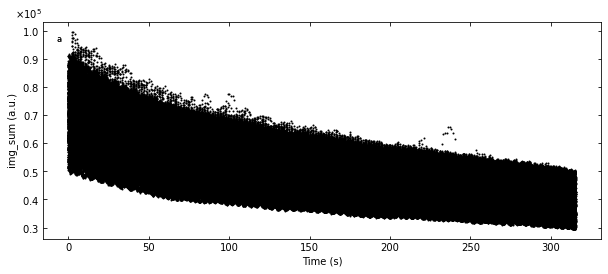

Gaussian fitted parameters in time: Fig. a: sum of original image, b: sum of reconstructed image, c: spot center in spot x coordinate, d: spot center in y coordinate, e: spot width in x coordinate, f: spot width in y coordinate.


In [17]:
growth_list = ['temp300']
D1_para.viz_RHEED_parameter_trend(growth_list, spot='spot_2', metric_list=['img_sum'], 
                                  head_tail=(100,300), interval=200, figsize=(10,4))

In [20]:
spot = 'spot_2'
metric = 'img_sum'
camera_freq = 2000
fit_settings = {'savgol_window_order': (50, 3), 'pca_component': 10, 'I_diff': 15000, 
                'unify':False, 'bounds':[0.001, 1], 'p_init':[0.1, 0.4, 0.1]}

growth_dict = {'temp300':1}
x_all, y_all = D1_para.load_multiple_curves(growth_dict.keys(), spot, metric, x_start=0, interval=0)

parameters_all, x_coor_all, info = analyze_curves(D1_para, growth_dict, spot, metric, interval=0, fit_settings=fit_settings)
[xs_all, ys_all, ys_fit_all, ys_nor_all, ys_nor_fit_all, ys_nor_fit_failed_all, labels_all, losses_all] = info

# define two color regime
x_y1 = x_coor_all[losses_all[:,0]>losses_all[:,1]]
x_y2 = x_coor_all[losses_all[:,0]<losses_all[:,1]]
color_array = Viz.two_color_array(x_coor_all, x_y1, x_y2, bgc1, bgc2, transparency=0.5)
color_array = np.concatenate([np.expand_dims(x_coor_all, 1), color_array], axis=1)
Viz.plot_fit_details(xs_all, ys_nor_all, ys_nor_fit_all, ys_nor_fit_failed_all, index_list=range(len(x_all)))

RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.

In [ ]:
fig, axes = layout_fig(4, 1, figsize=(6.5, 2*4))
Viz.plot_curve(axes[0], x_all, y_all, plot_type='lineplot', xlabel='Time (s)', ylabel='Intensity (a.u.)', xlim=(-2, 130), yaxis_style='sci')
Viz.plot_curve(axes[1], x_coor_all, parameters_all[:,0], plot_type='lineplot', xlabel='Time (s)', ylabel='Fitted a (a.u.)', xlim=(-2, 130))
Viz.plot_curve(axes[2], x_coor_all, parameters_all[:,1], plot_type='lineplot', xlabel='Time (s)', ylabel='Fitted b (a.u.)', xlim=(-2, 130))
Viz.plot_curve(axes[3], x_coor_all, parameters_all[:,2], plot_type='lineplot', xlabel='Time (s)', ylabel='Characteristic Time (s)', xlim=(-2, 130))
plt.show()

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(6, 2.5), layout='compressed')
ax1.scatter(sample_x, sample_y, color='k', s=1)
Viz.set_labels(ax1, xlabel='Time (s)', ylabel='Intensity (a.u.)', ticks_both_sides=False)

# n_std = 3
tau = parameters_all[:,2]
x_clean = x_list_all[np.where(tau < np.mean(tau) + n_std*np.std(tau))[0]]
tau = tau[np.where(tau < np.mean(tau) + n_std*np.std(tau))[0]]

x_clean = x_clean[np.where(tau > np.mean(tau) - n_std*np.std(tau))[0]]
tau = tau[np.where(tau > np.mean(tau) - n_std*np.std(tau))[0]]
# print('mean of tau:', np.mean(tau))

ax2 = ax1.twinx()
ax2.scatter(x_list_all, parameters_all[:,2], color=seq_colors[0], s=3)
ax2.plot(x_clean,  tau, color='#bc5090', markersize=3)
Viz.set_labels(ax2, ylabel='Characteristic Time (s)', yaxis_style='lineplot', ylim=(-0.05, 0.8), ticks_both_sides=False)
ax2.tick_params(axis="y", color='k', labelcolor=seq_colors[0])
ax2.set_ylabel('Characteristic Time (s)', color=seq_colors[0])
plt.title('mean of tau: '+str(np.mean(tau)))
plt.show()

### 2.2 J14-350C

img_sum


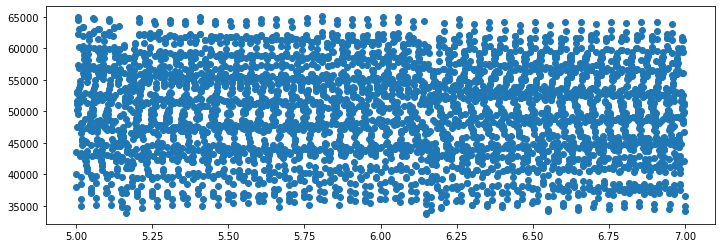

img_max


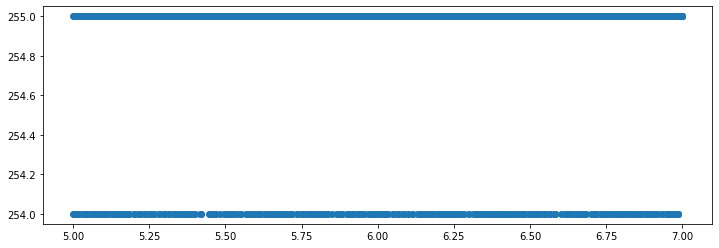

img_mean


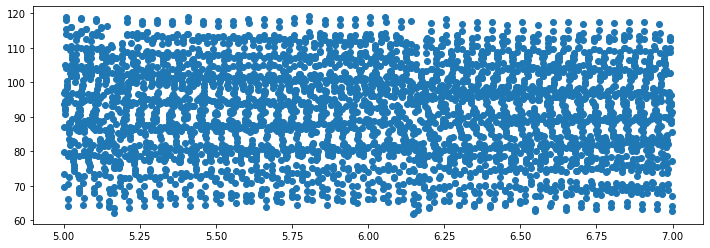

img_rec_sum


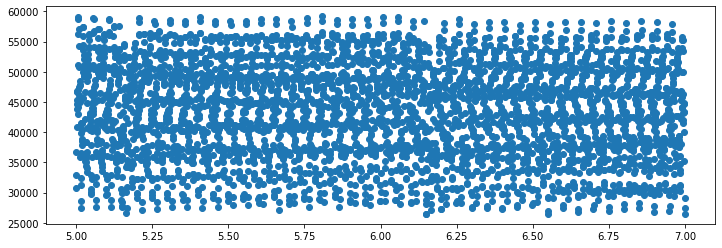

img_rec_max


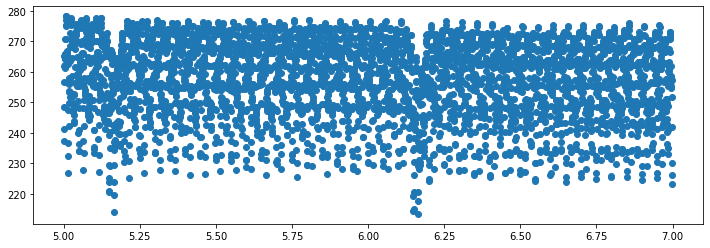

img_rec_mean


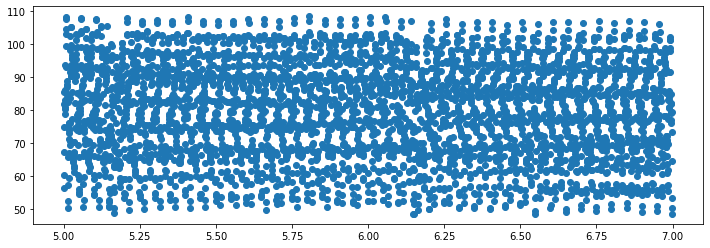

height


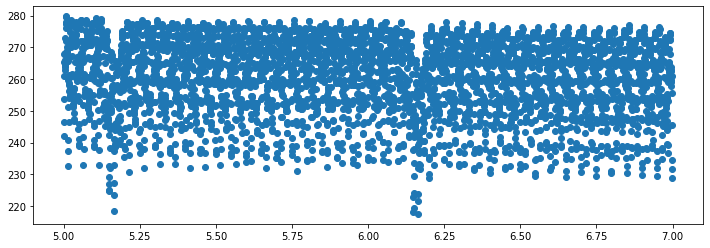

x


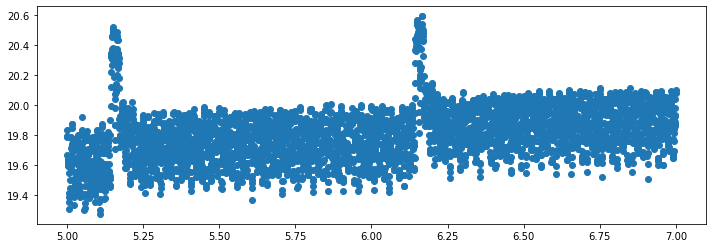

y


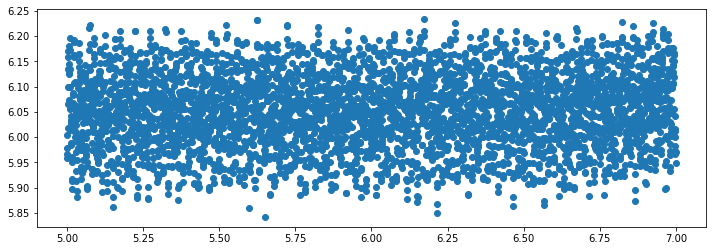

width_x


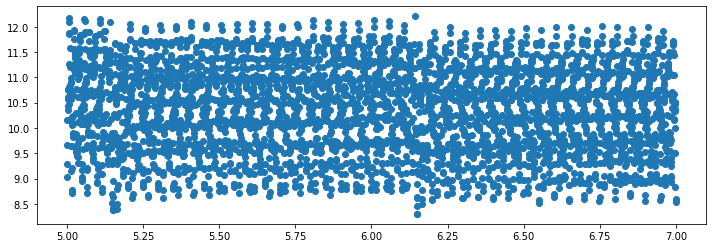

width_y


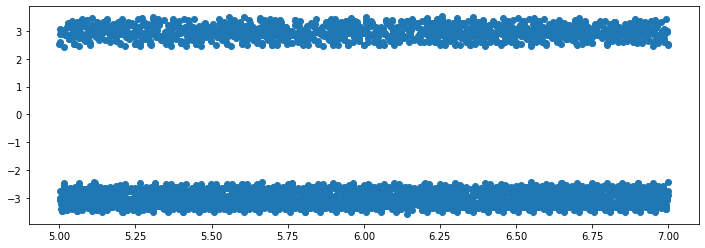

In [46]:
for m in ["img_sum", "img_max", "img_mean", "img_rec_sum", "img_rec_max", "img_rec_mean", 
          "height", "x", "y", "width_x", "width_y"]:
    x, y = D1_para.load_curve(growth='temp350', spot='spot_2', metric=m, x_start=0)
    print(m)
    plt.figure(figsize=(12,4))
    plt.scatter(x[10000:14000], y[10000:14000])
    plt.show()